In [1]:
import keras
import numpy as np
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from keras.optimizers import SGD, Adam, RMSprop

In [2]:
#Importing Important Libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)


2110848/2110848 [==============================] - 1s 1us/step


In [4]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

8982 train sequences
2246 test sequences


In [5]:
num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

46 classes


In [6]:
print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=10000)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Vectorizing sequence data...
x_train shape: (8982, 10000)
x_test shape: (2246, 10000)


In [7]:
print('Convert class vector to binary class matrix for use with categorical_crossentropy')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Convert class vector to binary class matrix for use with categorical_crossentropy
y_train shape: (8982, 46)
y_test shape: (2246, 46)


In [8]:
cv_folds = 2


In [9]:
parameters = {'neurons': [128, 256, 512],
              'optimizers': ["sgd", "sgd_momentum", "adam", "rmsprop"],
              'learning_rates' : [0.001, 0.005, 0.01],
              'batch_sizes': [16, 32, 64, 128]}


In [10]:
parameters

{'neurons': [128, 256, 512],
 'optimizers': ['sgd', 'sgd_momentum', 'adam', 'rmsprop'],
 'learning_rates': [0.001, 0.005, 0.01],
 'batch_sizes': [16, 32, 64, 128]}

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',patience=3, verbose=1, mode='min', baseline=None)
callbacks = [early_stopping]

In [12]:
def GridSearchCV_2(x_train, y_train, parameters, folds):
  
  trainscores = []
  valscores = []
  combinations = []
  
  for n in tqdm(parameters['neurons']):
    mlp = Sequential()
    mlp.add(Dense(n, input_shape=(10000,)))
    mlp.add(Activation('relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(num_classes))
    mlp.add(Activation('softmax'))
    
    for opt in tqdm(parameters['optimizers']):
      for lr in tqdm(parameters['learning_rates']):
        for batch in tqdm(parameters['batch_sizes']):

          
          #we store training and validation scores
          training_fold_scores = []
          cv_fold_scores = []
          
          #we iterate through the cv folds
          for j in range(0, cv_folds):
            
            #compiling model
            if opt == 'sgd':
              #we store the combinations 
              combinations.append("neurons: " + str(n) + 
                                  " optimizer: " + opt + 
                                  " learning rate: " + str(lr) +
                                  " batch size: " + str(batch))
              o = SGD(learning_rate = lr)
              mlp.compile(optimizer=o, loss='categorical_crossentropy', metrics=['accuracy'])
            
            elif opt == 'sgd_momentum':
              #we store the combinations
              combinations.append("neurons: " + str(n) + 
                                  " optimizer: " + opt + 
                                  "momentum: 0.9" +
                                  " learning rate: " + str(lr) +
                                  " batch size: " + str(batch))
              o = SGD(learning_rate = lr, momentum=0.9)
              mlp.compile(optimizer= o, loss='categorical_crossentropy', metrics=['accuracy'])
              
            elif opt == 'adam':
              #we store the combinations
              combinations.append("neurons: " + str(n) + 
                                  " optimizer: " + opt + 
                                  " learning rate: " + str(lr) +
                                  " batch size: " + str(batch))
              o = Adam(learning_rate = lr)
              mlp.compile(optimizer=o, loss='categorical_crossentropy', metrics=['accuracy'])
              
            else:
              #we store the combinations
              combinations.append("neurons: " + str(n) + 
                                  " optimizer: " + opt + 
                                  " learning rate: " + str(lr) +
                                  " batch size: " + str(batch))
              o = RMSprop(learning_rate = lr)
              mlp.compile(optimizer=o, loss='categorical_crossentropy', metrics=['accuracy'])
            
            #fitting model
            history = mlp.fit(x_train, y_train, 
                            epochs=20,
                            batch_size=batch,
                            validation_split=0.2,
                            callbacks= callbacks)
            
            #append last train_accuracy and last validation_accuracy
            training_fold_scores.append(history.history['accuracy'][-1])
            cv_fold_scores.append(history.history['val_accuracy'][-1])
          
                    
          #For each fold i.e folds=0,1,2 we have predicted accuracy for x_train and x_test. Since we have three values,
          #We will take means of three accuracies and appending them to trainscores and testscores.
          trainscores.append(np.mean(np.array(training_fold_scores)))
          valscores.append(np.mean(np.array(cv_fold_scores)))
    
  return trainscores, valscores, combinations


In [ ]:
trainscores, valscores, combinations = GridSearchCV_2(x_train, y_train, parameters, cv_folds)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 5s 4ms/step - loss: 3.5275 - accuracy: 0.3191 - val_loss: 3.1305 - val_accuracy: 0.4007
Epoch 2/2
450/450 [==============================] - 2s 3ms/step - loss: 2.8142 - accuracy: 0.4285 - val_loss: 2.4978 - val_accuracy: 0.4430
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 2.4020 - accuracy: 0.4608 - val_loss: 2.2198 - val_accuracy: 0.5153
Epoch 2/2
450/450 [==============================] - 2s 3ms/step - loss: 2.2072 - accuracy: 0.4824 - val_loss: 2.0653 - val_accuracy: 0.5186





 25%|██▌       | 1/4 [00:13<00:41, 13.75s/it]

Epoch 1/2
225/225 [==============================] - 2s 6ms/step - loss: 2.1045 - accuracy: 0.5030 - val_loss: 2.0073 - val_accuracy: 0.5214
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 2.0685 - accuracy: 0.5052 - val_loss: 1.9596 - val_accuracy: 0.5259
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 2.0258 - accuracy: 0.5080 - val_loss: 1.9188 - val_accuracy: 0.5259
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.9793 - accuracy: 0.5137 - val_loss: 1.8830 - val_accuracy: 0.5298





 50%|█████     | 2/4 [00:20<00:19,  9.88s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 1.9500 - accuracy: 0.5257 - val_loss: 1.8665 - val_accuracy: 0.5309
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 1.9362 - accuracy: 0.5260 - val_loss: 1.8507 - val_accuracy: 0.5320
Epoch 1/2
113/113 [==============================] - 1s 9ms/step - loss: 1.9316 - accuracy: 0.5280 - val_loss: 1.8364 - val_accuracy: 0.5387
Epoch 2/2
113/113 [==============================] - 1s 6ms/step - loss: 1.9070 - accuracy: 0.5261 - val_loss: 1.8221 - val_accuracy: 0.5398





 75%|███████▌  | 3/4 [00:27<00:08,  8.15s/it]

Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 1.9043 - accuracy: 0.5328 - val_loss: 1.8151 - val_accuracy: 0.5403
Epoch 2/2
57/57 [==============================] - 0s 8ms/step - loss: 1.8956 - accuracy: 0.5361 - val_loss: 1.8084 - val_accuracy: 0.5409
Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 1.8881 - accuracy: 0.5406 - val_loss: 1.8019 - val_accuracy: 0.5431
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 1.8765 - accuracy: 0.5378 - val_loss: 1.7955 - val_accuracy: 0.5459





100%|██████████| 4/4 [00:31<00:00,  7.86s/it]


 33%|███▎      | 1/3 [00:31<01:02, 31.45s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 1.7816 - accuracy: 0.5692 - val_loss: 1.6173 - val_accuracy: 0.6121
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.6293 - accuracy: 0.6143 - val_loss: 1.5077 - val_accuracy: 0.6561
Epoch 1/2
450/450 [==============================] - 3s 5ms/step - loss: 1.5190 - accuracy: 0.6527 - val_loss: 1.4270 - val_accuracy: 0.6800
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.4452 - accuracy: 0.6685 - val_loss: 1.3690 - val_accuracy: 0.6850





 25%|██▌       | 1/4 [00:10<00:32, 10.99s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 1.3805 - accuracy: 0.6839 - val_loss: 1.3379 - val_accuracy: 0.6995
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.3434 - accuracy: 0.6948 - val_loss: 1.3151 - val_accuracy: 0.7051
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 1.3200 - accuracy: 0.7035 - val_loss: 1.2919 - val_accuracy: 0.7062
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.2990 - accuracy: 0.7024 - val_loss: 1.2725 - val_accuracy: 0.7073





 50%|█████     | 2/4 [00:17<00:16,  8.21s/it]

Epoch 1/2
113/113 [==============================] - 1s 8ms/step - loss: 1.2649 - accuracy: 0.7157 - val_loss: 1.2630 - val_accuracy: 0.7101
Epoch 2/2
113/113 [==============================] - 1s 6ms/step - loss: 1.2570 - accuracy: 0.7183 - val_loss: 1.2540 - val_accuracy: 0.7129
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 1.2365 - accuracy: 0.7212 - val_loss: 1.2458 - val_accuracy: 0.7151
Epoch 2/2
113/113 [==============================] - 1s 4ms/step - loss: 1.2357 - accuracy: 0.7187 - val_loss: 1.2382 - val_accuracy: 0.7162





 75%|███████▌  | 3/4 [00:23<00:07,  7.24s/it]

Epoch 1/2
57/57 [==============================] - 1s 12ms/step - loss: 1.2178 - accuracy: 0.7225 - val_loss: 1.2343 - val_accuracy: 0.7179
Epoch 2/2
57/57 [==============================] - 0s 6ms/step - loss: 1.2134 - accuracy: 0.7246 - val_loss: 1.2303 - val_accuracy: 0.7201
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 1.2162 - accuracy: 0.7243 - val_loss: 1.2260 - val_accuracy: 0.7218
Epoch 2/2
57/57 [==============================] - 0s 6ms/step - loss: 1.2063 - accuracy: 0.7258 - val_loss: 1.2225 - val_accuracy: 0.7223





100%|██████████| 4/4 [00:27<00:00,  6.87s/it]


 67%|██████▋   | 2/3 [00:58<00:29, 29.13s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 1.1775 - accuracy: 0.7331 - val_loss: 1.1730 - val_accuracy: 0.7412
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.1110 - accuracy: 0.7482 - val_loss: 1.1315 - val_accuracy: 0.7468
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 1.0593 - accuracy: 0.7614 - val_loss: 1.0997 - val_accuracy: 0.7496
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.9928 - accuracy: 0.7754 - val_loss: 1.0685 - val_accuracy: 0.7613





 25%|██▌       | 1/4 [00:10<00:31, 10.36s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.9454 - accuracy: 0.7818 - val_loss: 1.0560 - val_accuracy: 0.7641
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.9295 - accuracy: 0.7894 - val_loss: 1.0428 - val_accuracy: 0.7657
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.9079 - accuracy: 0.7943 - val_loss: 1.0301 - val_accuracy: 0.7685
Epoch 2/2
225/225 [==============================] - 1s 6ms/step - loss: 0.8820 - accuracy: 0.8019 - val_loss: 1.0195 - val_accuracy: 0.7741





 50%|█████     | 2/4 [00:16<00:15,  7.88s/it]

Epoch 1/2
113/113 [==============================] - 1s 8ms/step - loss: 0.8699 - accuracy: 0.8021 - val_loss: 1.0120 - val_accuracy: 0.7735
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.8516 - accuracy: 0.8089 - val_loss: 1.0091 - val_accuracy: 0.7746
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.8546 - accuracy: 0.8040 - val_loss: 1.0051 - val_accuracy: 0.7752
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.8337 - accuracy: 0.8109 - val_loss: 0.9994 - val_accuracy: 0.7785





 75%|███████▌  | 3/4 [00:22<00:06,  6.95s/it]

Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.8208 - accuracy: 0.8163 - val_loss: 0.9977 - val_accuracy: 0.7791
Epoch 2/2
57/57 [==============================] - 0s 8ms/step - loss: 0.8259 - accuracy: 0.8096 - val_loss: 0.9951 - val_accuracy: 0.7780
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.8180 - accuracy: 0.8145 - val_loss: 0.9921 - val_accuracy: 0.7741
Epoch 2/2
57/57 [==============================] - 0s 6ms/step - loss: 0.8121 - accuracy: 0.8156 - val_loss: 0.9899 - val_accuracy: 0.7780





100%|██████████| 4/4 [00:26<00:00,  6.61s/it]


100%|██████████| 3/3 [01:25<00:00, 28.47s/it]

 25%|██▌       | 1/4 [01:25<04:16, 85.42s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 3s 5ms/step - loss: 0.8008 - accuracy: 0.8161 - val_loss: 0.9750 - val_accuracy: 0.7819
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.7738 - accuracy: 0.8238 - val_loss: 0.9621 - val_accuracy: 0.7863
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.7399 - accuracy: 0.8330 - val_loss: 0.9480 - val_accuracy: 0.7874
Epoch 2/2
450/450 [==============================] - 2s 5ms/step - loss: 0.7132 - accuracy: 0.8369 - val_loss: 0.9411 - val_accuracy: 0.7913





 25%|██▌       | 1/4 [00:10<00:30, 10.10s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.6800 - accuracy: 0.8459 - val_loss: 0.9320 - val_accuracy: 0.7930
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.6717 - accuracy: 0.8479 - val_loss: 0.9259 - val_accuracy: 0.7952
Epoch 1/2
225/225 [==============================] - 2s 6ms/step - loss: 0.6529 - accuracy: 0.8476 - val_loss: 0.9219 - val_accuracy: 0.7974
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.6404 - accuracy: 0.8568 - val_loss: 0.9145 - val_accuracy: 0.7947





 50%|█████     | 2/4 [00:16<00:16,  8.04s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.6282 - accuracy: 0.8586 - val_loss: 0.9132 - val_accuracy: 0.7958
Epoch 2/2
113/113 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.8625 - val_loss: 0.9107 - val_accuracy: 0.8002
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.6223 - accuracy: 0.8596 - val_loss: 0.9088 - val_accuracy: 0.7986
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.6178 - accuracy: 0.8569 - val_loss: 0.9054 - val_accuracy: 0.7991





 75%|███████▌  | 3/4 [00:23<00:07,  7.53s/it]

Epoch 1/2
57/57 [==============================] - 1s 12ms/step - loss: 0.6007 - accuracy: 0.8658 - val_loss: 0.9052 - val_accuracy: 0.7997
Epoch 2/2
57/57 [==============================] - 0s 9ms/step - loss: 0.6074 - accuracy: 0.8618 - val_loss: 0.9046 - val_accuracy: 0.8008
Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 0.6014 - accuracy: 0.8590 - val_loss: 0.9041 - val_accuracy: 0.8002
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.5995 - accuracy: 0.8660 - val_loss: 0.9034 - val_accuracy: 0.8013





100%|██████████| 4/4 [00:28<00:00,  7.04s/it]


 33%|███▎      | 1/3 [00:28<00:56, 28.16s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.6293 - accuracy: 0.8502 - val_loss: 0.9047 - val_accuracy: 0.7969
Epoch 2/2
450/450 [==============================] - 2s 3ms/step - loss: 0.5593 - accuracy: 0.8672 - val_loss: 0.8615 - val_accuracy: 0.8086
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.4863 - accuracy: 0.8873 - val_loss: 0.8487 - val_accuracy: 0.8175
Epoch 2/2
450/450 [==============================] - 2s 3ms/step - loss: 0.4243 - accuracy: 0.9031 - val_loss: 0.8454 - val_accuracy: 0.8108





 25%|██▌       | 1/4 [00:08<00:25,  8.44s/it]

Epoch 1/2
225/225 [==============================] - 2s 7ms/step - loss: 0.3552 - accuracy: 0.9197 - val_loss: 0.8475 - val_accuracy: 0.8147
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.3343 - accuracy: 0.9230 - val_loss: 0.8321 - val_accuracy: 0.8180
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.3127 - accuracy: 0.9299 - val_loss: 0.8407 - val_accuracy: 0.8203
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.2932 - accuracy: 0.9331 - val_loss: 0.8529 - val_accuracy: 0.8152





 50%|█████     | 2/4 [00:14<00:14,  7.23s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.2725 - accuracy: 0.9386 - val_loss: 0.8417 - val_accuracy: 0.8175
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.2637 - accuracy: 0.9376 - val_loss: 0.8482 - val_accuracy: 0.8180
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.2513 - accuracy: 0.9418 - val_loss: 0.8510 - val_accuracy: 0.8230
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.2503 - accuracy: 0.9395 - val_loss: 0.8506 - val_accuracy: 0.8164





 75%|███████▌  | 3/4 [00:20<00:06,  6.54s/it]

Epoch 1/2
57/57 [==============================] - 1s 16ms/step - loss: 0.2370 - accuracy: 0.9464 - val_loss: 0.8488 - val_accuracy: 0.8175
Epoch 2/2
57/57 [==============================] - 1s 9ms/step - loss: 0.2342 - accuracy: 0.9453 - val_loss: 0.8485 - val_accuracy: 0.8147
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.2282 - accuracy: 0.9491 - val_loss: 0.8496 - val_accuracy: 0.8191
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.2271 - accuracy: 0.9463 - val_loss: 0.8521 - val_accuracy: 0.8169





100%|██████████| 4/4 [00:24<00:00,  6.25s/it]


 67%|██████▋   | 2/3 [00:53<00:26, 26.30s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.3065 - accuracy: 0.9287 - val_loss: 0.9103 - val_accuracy: 0.8019
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.2937 - accuracy: 0.9296 - val_loss: 0.8882 - val_accuracy: 0.8058
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.2658 - accuracy: 0.9365 - val_loss: 0.9067 - val_accuracy: 0.8019
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.2342 - accuracy: 0.9425 - val_loss: 0.8869 - val_accuracy: 0.8097





 25%|██▌       | 1/4 [00:08<00:26,  8.85s/it]

Epoch 1/2
225/225 [==============================] - 2s 6ms/step - loss: 0.1875 - accuracy: 0.9514 - val_loss: 0.8967 - val_accuracy: 0.8114
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.1669 - accuracy: 0.9549 - val_loss: 0.9221 - val_accuracy: 0.8063
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.1589 - accuracy: 0.9556 - val_loss: 0.9299 - val_accuracy: 0.8152
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.1557 - accuracy: 0.9566 - val_loss: 0.9557 - val_accuracy: 0.8102





 50%|█████     | 2/4 [00:15<00:15,  7.83s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.1383 - accuracy: 0.9621 - val_loss: 0.9346 - val_accuracy: 0.8141
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.1329 - accuracy: 0.9605 - val_loss: 0.9336 - val_accuracy: 0.8147
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.1280 - accuracy: 0.9653 - val_loss: 0.9286 - val_accuracy: 0.8130
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.1237 - accuracy: 0.9613 - val_loss: 0.9326 - val_accuracy: 0.8114





 75%|███████▌  | 3/4 [00:20<00:06,  6.34s/it]

Epoch 1/2
57/57 [==============================] - 2s 14ms/step - loss: 0.1250 - accuracy: 0.9644 - val_loss: 0.9393 - val_accuracy: 0.8164
Epoch 2/2
57/57 [==============================] - 0s 6ms/step - loss: 0.1133 - accuracy: 0.9665 - val_loss: 0.9491 - val_accuracy: 0.8136
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.1145 - accuracy: 0.9666 - val_loss: 0.9524 - val_accuracy: 0.8147
Epoch 2/2
57/57 [==============================] - 0s 8ms/step - loss: 0.1148 - accuracy: 0.9666 - val_loss: 0.9541 - val_accuracy: 0.8136





100%|██████████| 4/4 [00:25<00:00,  6.47s/it]


100%|██████████| 3/3 [01:19<00:00, 26.35s/it]

 50%|█████     | 2/4 [02:44<02:43, 81.68s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.2206 - accuracy: 0.9434 - val_loss: 1.0208 - val_accuracy: 0.8058
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.2092 - accuracy: 0.9518 - val_loss: 1.0370 - val_accuracy: 0.8114
Epoch 1/2
450/450 [==============================] - 3s 6ms/step - loss: 0.2111 - accuracy: 0.9525 - val_loss: 1.1830 - val_accuracy: 0.8091
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.1964 - accuracy: 0.9566 - val_loss: 1.2750 - val_accuracy: 0.8080





 25%|██▌       | 1/4 [00:11<00:33, 11.14s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.1707 - accuracy: 0.9602 - val_loss: 1.4668 - val_accuracy: 0.7997
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.1619 - accuracy: 0.9605 - val_loss: 1.4833 - val_accuracy: 0.8063
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.1549 - accuracy: 0.9635 - val_loss: 1.6238 - val_accuracy: 0.8052
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.1491 - accuracy: 0.9642 - val_loss: 1.5939 - val_accuracy: 0.8041





 50%|█████     | 2/4 [00:17<00:16,  8.35s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.1296 - accuracy: 0.9655 - val_loss: 1.7381 - val_accuracy: 0.8069
Epoch 2/2
113/113 [==============================] - 1s 7ms/step - loss: 0.1375 - accuracy: 0.9652 - val_loss: 1.7526 - val_accuracy: 0.8047
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.1232 - accuracy: 0.9648 - val_loss: 1.9471 - val_accuracy: 0.8058
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.1315 - accuracy: 0.9644 - val_loss: 1.8967 - val_accuracy: 0.8047





 75%|███████▌  | 3/4 [00:23<00:07,  7.20s/it]

Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.1153 - accuracy: 0.9676 - val_loss: 1.9516 - val_accuracy: 0.8030
Epoch 2/2
57/57 [==============================] - 0s 8ms/step - loss: 0.1218 - accuracy: 0.9670 - val_loss: 1.9966 - val_accuracy: 0.8036
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.1122 - accuracy: 0.9687 - val_loss: 2.0598 - val_accuracy: 0.8041
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.1094 - accuracy: 0.9699 - val_loss: 2.1171 - val_accuracy: 0.8024





100%|██████████| 4/4 [00:27<00:00,  6.88s/it]


 33%|███▎      | 1/3 [00:27<00:55, 27.51s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.5034 - accuracy: 0.9081 - val_loss: 1.8177 - val_accuracy: 0.7835
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.6505 - accuracy: 0.8976 - val_loss: 2.0748 - val_accuracy: 0.7785
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.6755 - accuracy: 0.9052 - val_loss: 2.4935 - val_accuracy: 0.7852
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.6903 - accuracy: 0.9081 - val_loss: 2.6568 - val_accuracy: 0.7763





 25%|██▌       | 1/4 [00:09<00:27,  9.27s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.5828 - accuracy: 0.9212 - val_loss: 3.2754 - val_accuracy: 0.7835
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.4771 - accuracy: 0.9326 - val_loss: 3.3953 - val_accuracy: 0.7813
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.4991 - accuracy: 0.9365 - val_loss: 3.7908 - val_accuracy: 0.7813
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.4813 - accuracy: 0.9335 - val_loss: 3.6944 - val_accuracy: 0.7841





 50%|█████     | 2/4 [00:15<00:14,  7.27s/it]

Epoch 1/2
113/113 [==============================] - 2s 10ms/step - loss: 0.4346 - accuracy: 0.9436 - val_loss: 4.0372 - val_accuracy: 0.7835
Epoch 2/2
113/113 [==============================] - 1s 6ms/step - loss: 0.4401 - accuracy: 0.9438 - val_loss: 4.0235 - val_accuracy: 0.7696
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.4276 - accuracy: 0.9461 - val_loss: 4.6108 - val_accuracy: 0.7774
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.3776 - accuracy: 0.9450 - val_loss: 4.7266 - val_accuracy: 0.7674





 75%|███████▌  | 3/4 [00:21<00:06,  6.85s/it]

Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.3534 - accuracy: 0.9525 - val_loss: 5.0112 - val_accuracy: 0.7796
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.2925 - accuracy: 0.9524 - val_loss: 5.1247 - val_accuracy: 0.7713
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.3038 - accuracy: 0.9539 - val_loss: 5.3080 - val_accuracy: 0.7702
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.2835 - accuracy: 0.9537 - val_loss: 5.2726 - val_accuracy: 0.7791





100%|██████████| 4/4 [00:25<00:00,  6.41s/it]


 67%|██████▋   | 2/3 [00:53<00:26, 26.42s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 5ms/step - loss: 0.7830 - accuracy: 0.9079 - val_loss: 6.0818 - val_accuracy: 0.7457
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.3177 - accuracy: 0.8601 - val_loss: 4.8976 - val_accuracy: 0.7401
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 1.4772 - accuracy: 0.8696 - val_loss: 5.3375 - val_accuracy: 0.7401
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.5305 - accuracy: 0.8472 - val_loss: 5.7254 - val_accuracy: 0.7190





 25%|██▌       | 1/4 [00:11<00:33, 11.07s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 1.2631 - accuracy: 0.8831 - val_loss: 6.2662 - val_accuracy: 0.7412
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.0785 - accuracy: 0.8764 - val_loss: 5.6754 - val_accuracy: 0.7429
Epoch 1/2
225/225 [==============================] - 2s 6ms/step - loss: 1.0794 - accuracy: 0.8860 - val_loss: 6.7015 - val_accuracy: 0.7446
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.0057 - accuracy: 0.8863 - val_loss: 5.9845 - val_accuracy: 0.7468





 50%|█████     | 2/4 [00:18<00:17,  8.87s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.9266 - accuracy: 0.8974 - val_loss: 7.6207 - val_accuracy: 0.7546
Epoch 2/2
113/113 [==============================] - 1s 4ms/step - loss: 0.7000 - accuracy: 0.9084 - val_loss: 8.0236 - val_accuracy: 0.7518
Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.6384 - accuracy: 0.9165 - val_loss: 9.5552 - val_accuracy: 0.7674
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.8869 - accuracy: 0.9140 - val_loss: 8.3226 - val_accuracy: 0.7518





 75%|███████▌  | 3/4 [00:26<00:08,  8.32s/it]

Epoch 1/2
57/57 [==============================] - 1s 16ms/step - loss: 0.5513 - accuracy: 0.9262 - val_loss: 9.5406 - val_accuracy: 0.7585
Epoch 2/2
57/57 [==============================] - 0s 8ms/step - loss: 0.6467 - accuracy: 0.9201 - val_loss: 9.5758 - val_accuracy: 0.7707
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.5997 - accuracy: 0.9268 - val_loss: 9.7137 - val_accuracy: 0.7707
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.5186 - accuracy: 0.9257 - val_loss: 9.1486 - val_accuracy: 0.7507





100%|██████████| 4/4 [00:31<00:00,  8.00s/it]


100%|██████████| 3/3 [01:25<00:00, 28.39s/it]

 75%|███████▌  | 3/4 [04:09<01:23, 83.28s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.4878 - accuracy: 0.9278 - val_loss: 9.5217 - val_accuracy: 0.7518
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.5067 - accuracy: 0.9344 - val_loss: 9.8380 - val_accuracy: 0.7551
Epoch 1/2
450/450 [==============================] - 3s 6ms/step - loss: 0.4195 - accuracy: 0.9336 - val_loss: 10.2195 - val_accuracy: 0.7607
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.4208 - accuracy: 0.9379 - val_loss: 10.4196 - val_accuracy: 0.7624





 25%|██▌       | 1/4 [00:10<00:30, 10.14s/it]

Epoch 1/2
225/225 [==============================] - 2s 5ms/step - loss: 0.4346 - accuracy: 0.9374 - val_loss: 10.6009 - val_accuracy: 0.7674
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.4439 - accuracy: 0.9383 - val_loss: 10.6185 - val_accuracy: 0.7657
Epoch 1/2
225/225 [==============================] - 2s 6ms/step - loss: 0.3980 - accuracy: 0.9438 - val_loss: 10.7471 - val_accuracy: 0.7657
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.4374 - accuracy: 0.9363 - val_loss: 10.8071 - val_accuracy: 0.7691





 50%|█████     | 2/4 [00:16<00:15,  7.95s/it]

Epoch 1/2
113/113 [==============================] - 1s 8ms/step - loss: 0.3706 - accuracy: 0.9468 - val_loss: 11.0002 - val_accuracy: 0.7679
Epoch 2/2
113/113 [==============================] - 1s 7ms/step - loss: 0.3934 - accuracy: 0.9411 - val_loss: 10.9705 - val_accuracy: 0.7674
Epoch 1/2
113/113 [==============================] - 1s 8ms/step - loss: 0.4091 - accuracy: 0.9434 - val_loss: 11.0328 - val_accuracy: 0.7696
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.4298 - accuracy: 0.9441 - val_loss: 11.0353 - val_accuracy: 0.7679





 75%|███████▌  | 3/4 [00:23<00:07,  7.55s/it]

Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 0.3543 - accuracy: 0.9491 - val_loss: 11.0662 - val_accuracy: 0.7679
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.3346 - accuracy: 0.9460 - val_loss: 11.0137 - val_accuracy: 0.7702
Epoch 1/2
57/57 [==============================] - 1s 15ms/step - loss: 0.3858 - accuracy: 0.9414 - val_loss: 11.0955 - val_accuracy: 0.7713
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.3146 - accuracy: 0.9477 - val_loss: 11.0588 - val_accuracy: 0.7718





100%|██████████| 4/4 [00:29<00:00,  7.41s/it]


 33%|███▎      | 1/3 [00:29<00:59, 29.66s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 3s 5ms/step - loss: 0.4155 - accuracy: 0.9438 - val_loss: 11.6858 - val_accuracy: 0.7785
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.5297 - accuracy: 0.9395 - val_loss: 11.8255 - val_accuracy: 0.7741
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.4149 - accuracy: 0.9407 - val_loss: 11.9826 - val_accuracy: 0.7718
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.3586 - accuracy: 0.9453 - val_loss: 12.8631 - val_accuracy: 0.7763





 25%|██▌       | 1/4 [00:11<00:34, 11.49s/it]

Epoch 1/2
225/225 [==============================] - 2s 7ms/step - loss: 0.4304 - accuracy: 0.9442 - val_loss: 12.5584 - val_accuracy: 0.7746
Epoch 2/2
225/225 [==============================] - 1s 5ms/step - loss: 0.3805 - accuracy: 0.9461 - val_loss: 12.3431 - val_accuracy: 0.7752
Epoch 1/2
225/225 [==============================] - 2s 5ms/step - loss: 0.3999 - accuracy: 0.9432 - val_loss: 12.4398 - val_accuracy: 0.7780
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.3065 - accuracy: 0.9474 - val_loss: 12.4283 - val_accuracy: 0.7796





 50%|█████     | 2/4 [00:20<00:20, 10.18s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.3840 - accuracy: 0.9454 - val_loss: 12.1173 - val_accuracy: 0.7796
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.3552 - accuracy: 0.9441 - val_loss: 11.9421 - val_accuracy: 0.7752
Epoch 1/2
113/113 [==============================] - 2s 10ms/step - loss: 0.3358 - accuracy: 0.9470 - val_loss: 12.3189 - val_accuracy: 0.7769
Epoch 2/2
113/113 [==============================] - 1s 7ms/step - loss: 0.3048 - accuracy: 0.9481 - val_loss: 12.1272 - val_accuracy: 0.7702





 75%|███████▌  | 3/4 [00:27<00:08,  8.84s/it]

Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 0.2939 - accuracy: 0.9456 - val_loss: 12.3781 - val_accuracy: 0.7780
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.2972 - accuracy: 0.9521 - val_loss: 11.8556 - val_accuracy: 0.7780
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 0.3289 - accuracy: 0.9499 - val_loss: 12.2701 - val_accuracy: 0.7741
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.3365 - accuracy: 0.9478 - val_loss: 12.0037 - val_accuracy: 0.7741





100%|██████████| 4/4 [00:32<00:00,  8.04s/it]


 67%|██████▋   | 2/3 [01:01<00:31, 31.15s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.3625 - accuracy: 0.9429 - val_loss: 13.1538 - val_accuracy: 0.7730
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.4335 - accuracy: 0.9460 - val_loss: 13.5309 - val_accuracy: 0.7813
Epoch 1/2
450/450 [==============================] - 3s 5ms/step - loss: 0.4998 - accuracy: 0.9445 - val_loss: 13.1761 - val_accuracy: 0.7841
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 0.5643 - accuracy: 0.9434 - val_loss: 13.1915 - val_accuracy: 0.7791





 25%|██▌       | 1/4 [00:11<00:33, 11.04s/it]

Epoch 1/2
225/225 [==============================] - 2s 5ms/step - loss: 0.4887 - accuracy: 0.9367 - val_loss: 13.0713 - val_accuracy: 0.7763
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.4056 - accuracy: 0.9404 - val_loss: 13.1089 - val_accuracy: 0.7780
Epoch 1/2
225/225 [==============================] - 2s 5ms/step - loss: 0.4580 - accuracy: 0.9404 - val_loss: 12.8222 - val_accuracy: 0.7685
Epoch 2/2
225/225 [==============================] - 1s 5ms/step - loss: 0.4085 - accuracy: 0.9449 - val_loss: 12.8666 - val_accuracy: 0.7713





 50%|█████     | 2/4 [00:18<00:17,  8.72s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 0.4441 - accuracy: 0.9449 - val_loss: 13.0128 - val_accuracy: 0.7724
Epoch 2/2
113/113 [==============================] - 1s 6ms/step - loss: 0.5058 - accuracy: 0.9403 - val_loss: 11.9686 - val_accuracy: 0.7696
Epoch 1/2
113/113 [==============================] - 2s 8ms/step - loss: 0.3865 - accuracy: 0.9379 - val_loss: 12.8889 - val_accuracy: 0.7702
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.3412 - accuracy: 0.9463 - val_loss: 13.1154 - val_accuracy: 0.7663





 75%|███████▌  | 3/4 [00:24<00:07,  7.57s/it]

Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 0.3594 - accuracy: 0.9439 - val_loss: 13.1053 - val_accuracy: 0.7763
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.4121 - accuracy: 0.9456 - val_loss: 12.6293 - val_accuracy: 0.7707
Epoch 1/2
57/57 [==============================] - 1s 12ms/step - loss: 0.3983 - accuracy: 0.9435 - val_loss: 12.9054 - val_accuracy: 0.7713
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.3499 - accuracy: 0.9436 - val_loss: 12.9654 - val_accuracy: 0.7663





100%|██████████| 4/4 [00:28<00:00,  7.19s/it]


100%|██████████| 3/3 [01:30<00:00, 30.21s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 3s 5ms/step - loss: 3.5345 - accuracy: 0.3056 - val_loss: 3.1440 - val_accuracy: 0.3695
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 2.8168 - accuracy: 0.4121 - val_loss: 2.5304 - val_accuracy: 0.4402
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 2.4077 - accuracy: 0.4649 - val_loss: 2.2329 - val_accuracy: 0.5025
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 2.1891 - accuracy: 0.4931 - val_loss: 2.0527 - val_accuracy: 0.5181





 25%|██▌       | 1/4 [00:11<00:33, 11.12s/it]

Epoch 1/2
225/225 [==============================] - 2s 6ms/step - loss: 2.0645 - accuracy: 0.5116 - val_loss: 1.9879 - val_accuracy: 0.5209
Epoch 2/2
225/225 [==============================] - 1s 5ms/step - loss: 2.0124 - accuracy: 0.5187 - val_loss: 1.9349 - val_accuracy: 0.5275
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 1.9754 - accuracy: 0.5225 - val_loss: 1.8912 - val_accuracy: 0.5337
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.9314 - accuracy: 0.5301 - val_loss: 1.8541 - val_accuracy: 0.5431





 50%|█████     | 2/4 [00:17<00:16,  8.34s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 1.8973 - accuracy: 0.5406 - val_loss: 1.8373 - val_accuracy: 0.5487
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 1.8842 - accuracy: 0.5424 - val_loss: 1.8218 - val_accuracy: 0.5526
Epoch 1/2
113/113 [==============================] - 1s 8ms/step - loss: 1.8669 - accuracy: 0.5482 - val_loss: 1.8071 - val_accuracy: 0.5570
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 1.8572 - accuracy: 0.5510 - val_loss: 1.7933 - val_accuracy: 0.5609





 75%|███████▌  | 3/4 [00:24<00:07,  7.68s/it]

Epoch 1/2
57/57 [==============================] - 1s 16ms/step - loss: 1.8405 - accuracy: 0.5525 - val_loss: 1.7863 - val_accuracy: 0.5643
Epoch 2/2
57/57 [==============================] - 1s 10ms/step - loss: 1.8382 - accuracy: 0.5514 - val_loss: 1.7798 - val_accuracy: 0.5671
Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 1.8234 - accuracy: 0.5580 - val_loss: 1.7735 - val_accuracy: 0.5698
Epoch 2/2
57/57 [==============================] - 0s 8ms/step - loss: 1.8225 - accuracy: 0.5545 - val_loss: 1.7673 - val_accuracy: 0.5715





100%|██████████| 4/4 [00:29<00:00,  7.28s/it]


 33%|███▎      | 1/3 [00:29<00:58, 29.15s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 1.7278 - accuracy: 0.5820 - val_loss: 1.6006 - val_accuracy: 0.6377
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.5791 - accuracy: 0.6322 - val_loss: 1.4940 - val_accuracy: 0.6644
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 1.4732 - accuracy: 0.6640 - val_loss: 1.4108 - val_accuracy: 0.6778
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.3830 - accuracy: 0.6842 - val_loss: 1.3485 - val_accuracy: 0.6950





 25%|██▌       | 1/4 [00:10<00:32, 10.78s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 1.3230 - accuracy: 0.7008 - val_loss: 1.3221 - val_accuracy: 0.7023
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.2867 - accuracy: 0.7063 - val_loss: 1.2957 - val_accuracy: 0.7067
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 1.2602 - accuracy: 0.7118 - val_loss: 1.2740 - val_accuracy: 0.7151
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 1.2270 - accuracy: 0.7237 - val_loss: 1.2535 - val_accuracy: 0.7229





 50%|█████     | 2/4 [00:17<00:16,  8.21s/it]

Epoch 1/2
113/113 [==============================] - 1s 7ms/step - loss: 1.1967 - accuracy: 0.7328 - val_loss: 1.2436 - val_accuracy: 0.7234
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 1.1892 - accuracy: 0.7292 - val_loss: 1.2342 - val_accuracy: 0.7273
Epoch 1/2
113/113 [==============================] - 1s 8ms/step - loss: 1.1707 - accuracy: 0.7357 - val_loss: 1.2254 - val_accuracy: 0.7295
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 1.1603 - accuracy: 0.7379 - val_loss: 1.2170 - val_accuracy: 0.7323





 75%|███████▌  | 3/4 [00:24<00:07,  7.72s/it]

Epoch 1/2
57/57 [==============================] - 1s 12ms/step - loss: 1.1511 - accuracy: 0.7427 - val_loss: 1.2125 - val_accuracy: 0.7323
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 1.1475 - accuracy: 0.7435 - val_loss: 1.2085 - val_accuracy: 0.7351
Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 1.1409 - accuracy: 0.7438 - val_loss: 1.2046 - val_accuracy: 0.7379
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 1.1342 - accuracy: 0.7445 - val_loss: 1.2004 - val_accuracy: 0.7373





100%|██████████| 4/4 [00:28<00:00,  7.12s/it]


 67%|██████▋   | 2/3 [00:57<00:28, 28.77s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 1.1135 - accuracy: 0.7520 - val_loss: 1.1467 - val_accuracy: 0.7501
Epoch 2/2
450/450 [==============================] - 2s 4ms/step - loss: 1.0410 - accuracy: 0.7680 - val_loss: 1.1181 - val_accuracy: 0.7524
Epoch 1/2
450/450 [==============================] - 2s 4ms/step - loss: 0.9683 - accuracy: 0.7805 - val_loss: 1.0672 - val_accuracy: 0.7641
Epoch 2/2
450/450 [==============================] - 2s 3ms/step - loss: 0.9197 - accuracy: 0.7964 - val_loss: 1.0615 - val_accuracy: 0.7551





 25%|██▌       | 1/4 [00:09<00:27,  9.13s/it]

Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.8723 - accuracy: 0.8024 - val_loss: 1.0238 - val_accuracy: 0.7702
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.8423 - accuracy: 0.8127 - val_loss: 1.0144 - val_accuracy: 0.7735
Epoch 1/2
225/225 [==============================] - 1s 5ms/step - loss: 0.8145 - accuracy: 0.8171 - val_loss: 1.0021 - val_accuracy: 0.7780
Epoch 2/2
225/225 [==============================] - 1s 4ms/step - loss: 0.8027 - accuracy: 0.8195 - val_loss: 0.9913 - val_accuracy: 0.7774





 50%|█████     | 2/4 [00:14<00:14,  7.15s/it]

Epoch 1/2
113/113 [==============================] - 1s 10ms/step - loss: 0.7799 - accuracy: 0.8252 - val_loss: 0.9872 - val_accuracy: 0.7774
Epoch 2/2
113/113 [==============================] - 1s 6ms/step - loss: 0.7715 - accuracy: 0.8245 - val_loss: 0.9823 - val_accuracy: 0.7791
Epoch 1/2
113/113 [==============================] - 1s 8ms/step - loss: 0.7489 - accuracy: 0.8287 - val_loss: 0.9777 - val_accuracy: 0.7802
Epoch 2/2
113/113 [==============================] - 1s 5ms/step - loss: 0.7477 - accuracy: 0.8315 - val_loss: 0.9719 - val_accuracy: 0.7802





 75%|███████▌  | 3/4 [00:20<00:06,  6.26s/it]

Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 0.7392 - accuracy: 0.8281 - val_loss: 0.9695 - val_accuracy: 0.7802
Epoch 2/2
57/57 [==============================] - 0s 7ms/step - loss: 0.7304 - accuracy: 0.8337 - val_loss: 0.9673 - val_accuracy: 0.7802


In [66]:
#identify the best combination

max_val_accuracy = (max(valscores))
max_val_index = valscores.index(max_val_accuracy)


In [67]:
max_val_index

10

In [68]:
print("Best validation accuracy: {} \n Best combination is:\n {} ".format(max_val_accuracy, combinations[max_val_index]))

The best combination is: optimizer: sgd_momentum learning rate of 0.0001 with a validation accuracy of 0.82 and an accuracy of 0.95 


TypeError: ignored

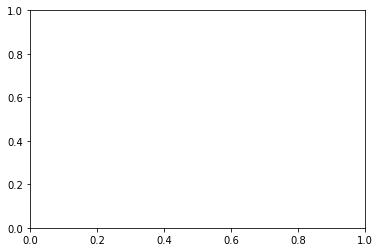

In [ ]:
plt.plot(combinations, trainscores, label='Train accuracy scores curve')
plt.plot(combinations, valscores, label='CV accuracy scores curve')
plt.title('Hyper-Parameter VS Accuracy Plot')
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

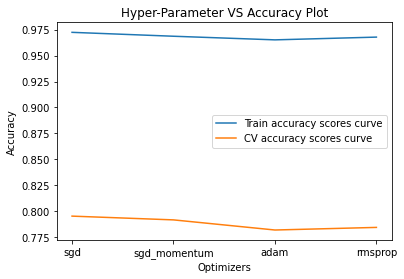

In [ ]:
plt.plot(["sgd","sgd_momentum","adam","rmsprop"], trainscores, label='Train accuracy scores curve')
plt.plot(["sgd","sgd_momentum","adam","rmsprop"], valscores, label='CV accuracy scores curve')
plt.title('Hyper-Parameter VS Accuracy Plot')
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def GridSearchCV(x_train, y_train, model, optimizers, folds):
  
  trainscores = []
  testscores = []

  for opt in tqdm(parameters['optimizers']):
    training_fold_scores = []
    cv_fold_scores = []

    for j in range(0, cv_folds):
      training_data = select_data_without_duplicates(x_train) 
      cv_data = list(set(list(range(1, len(x_train)))) - set(training_data))
      
      #Evaluating X_train, Y_train, X_test, Y_test data from new split
      X_train = x_train[training_data]
      X_cv = x_train[cv_data]
      Y_train = y_train[training_data]
      Y_cv = y_train[cv_data]
      
      #compiling model
      model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

      #fitting model
      model.fit(X_train, Y_train, epochs=2)

      #Predicting accuracy for X_test data and appending value to testing_fold_scores
      Y_cv_predict = model.predict(X_cv)
      Y_cv_predict = np.argmax(Y_cv_predict, axis=1)
      Y_cv = np.argmax(Y_cv, axis=1)
      cv_fold_scores.append(accuracy_score(Y_cv, Y_cv_predict))
      #Predicting accuracy for X_test data and appending value to training_fold_scores
      Y_train_predict = model.predict(X_train)
      Y_train_predict = np.argmax(Y_train_predict, axis=1)
      Y_train = np.argmax(Y_train, axis=1)
      training_fold_scores.append(accuracy_score(Y_train, Y_train_predict))
    
    #For each fold i.e folds=0,1,2 we have predicted accuracy for x_train and x_test. Since we have three values,
    #We will take means of three accuracies and appending them to trainscores and testscores.
    trainscores.append(np.mean(np.array(training_fold_scores)))
    testscores.append(np.mean(np.array(cv_fold_scores)))
    
  return trainscores,testscores



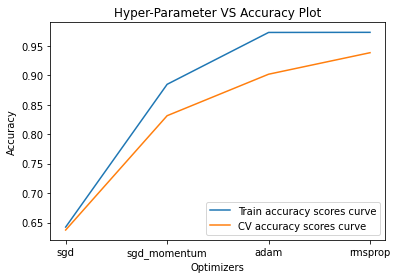

In [ ]:
plt.plot(["sgd","sgd_momentum","adam","rmsprop"], trainscores, label='Train accuracy scores curve')
plt.plot(["sgd","sgd_momentum","adam","rmsprop"], testscores, label='CV accuracy scores curve')
plt.title('Hyper-Parameter VS Accuracy Plot')
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We obviously need to increment the number of epochs, this was just a try